# import the preprocessed datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import tree, metrics
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn

In [2]:
train = pd.read_csv('../data_frames/politik/train_data', index_col=None, header=0)
test = pd.read_csv('../data_frames/politik/test_data', index_col=None, header=0)

In [3]:
hot_train_data = train.copy()
hot_train_data[hot_train_data > 0] = 1

In [4]:
hot_test_data = test.copy()
hot_test_data[hot_test_data > 0] = 1

## assign data to variables

In [5]:
y_train = hot_train_data['goal_val'].values
y_test = hot_test_data['goal_val'].values
X_train = hot_train_data.drop(['goal_val'], axis=1).values
X_test = hot_test_data.drop(['goal_val'], axis=1).values

In [6]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [7]:
dtype = torch.float
device = torch.device("cpu")

In [8]:
x_torch_train = torch.tensor(X_train, device=device, dtype=dtype)

y_torch_train = torch.tensor(y_train, device=device, dtype=torch.long)

x_torch_val = torch.tensor(X_val, device=device, dtype=dtype)

y_torch_val = torch.tensor(y_val, device=device, dtype=torch.long)

In [9]:
x_torch_train.shape

torch.Size([1136, 400])

In [10]:
y_torch_train.shape

torch.Size([1136])

---

In [11]:
# N sind die Anzahl der Datenpunkte 
# D_in ist die Input-Dimension
# D_out ist die Output-Dimension
D_in, N_classes = 400, 50
H = 256

In [12]:
### 2-Layer-Network
model = torch.nn.Sequential(   
    nn.Linear(D_in, H),
    nn.ReLU(),
    #nn.Linear(H, H2),
    #nn.ReLU(),
    nn.Linear(H, N_classes)
)

In [13]:
learning_rate = 0.001
weight_decay = 0.01

In [14]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

In [15]:
loss_hist = []
val_loss_hist = []

In [16]:
# Train
for t in range(1000):
    # Berechne die Vorhersage (foward step)
    outputs = model(x_torch_train)
    val_outputs = model(x_torch_val) 
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    loss = criterion(outputs, y_torch_train)
    val_loss = criterion(val_outputs, y_torch_val)
    # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    #if t % 1000 == 0:
    loss_hist.append(loss.item())
    val_loss_hist.append(val_loss.item())
    #    print(t, loss.item())

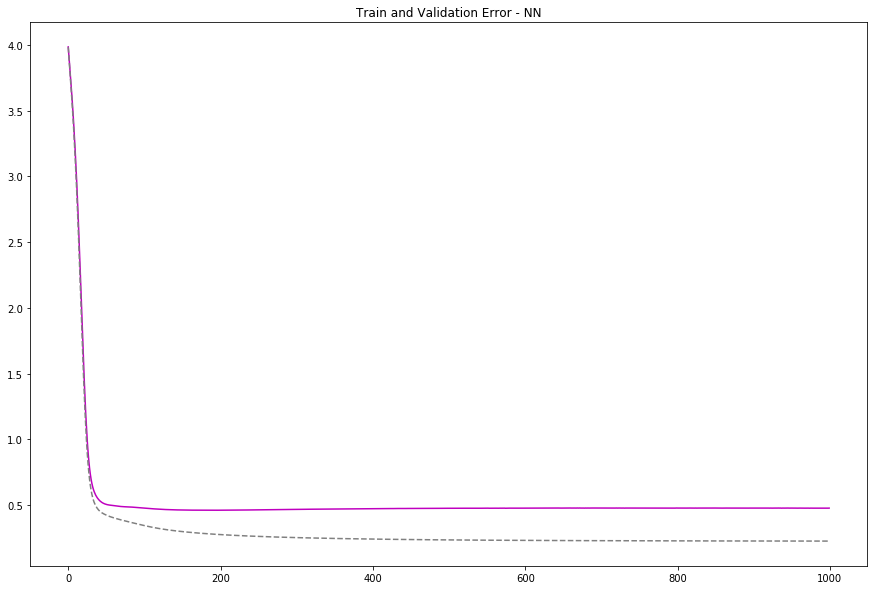

In [17]:
plt.figure(1, figsize=(15,10))
plt.plot(val_loss_hist, color='m', lw=1.5)
plt.plot(loss_hist, color='grey', lw=1.5, linestyle='--')
plt.title('Train and Validation Error - NN')
plt.show();

In [18]:
torch.max(model(x_torch_train), 1)

(tensor([6.7197, 7.6551, 8.0468,  ..., 9.0374, 9.0955, 8.2257],
        grad_fn=<MaxBackward0>), tensor([1, 1, 1,  ..., 0, 0, 0]))

---

In [19]:
x_torch_test = torch.tensor(X_test, device=device, dtype=dtype)

y_torch_test = torch.tensor(y_test,device=device, dtype=torch.long)

In [20]:
softmax = torch.nn.Softmax()

y_test_pred = softmax(model(x_torch_test)).argmax(1)

/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
test_error = mean_squared_error (y_torch_test, y_test_pred)

In [22]:
test_error
print(f'The TEST prediction is {(1 - test_error)*100} % ACCURATE')

The TEST prediction is 88.51063829787233 % ACCURATE


---